<hr>

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/UNAL_Aplicación_Medell%C3%ADn.svg/1280px-UNAL_Aplicación_Medell%C3%ADn.svg.png" width="300"/>

<img align="left" src="http://www.redttu.edu.co/es/wp-content/uploads/2016/01/itm.png" width="300"/> 
    
<img align="left" src="https://www.cienciasdelaadministracion.uns.edu.ar/wp-content/themes/enlighten-pro/images/logo-uns-horizontal.png" width="300"/>


<hr>

#### Pedro Atencio Ortiz - 2019

# 1. Regresor logístico como una neurona

En este notebook abordaremos los siguientes tópicos:

- Análisis desde el grafo de cómputo.
- Implementación tradicional.
- Broadcasting / Vectorization.
- Implementación vectorizada.
- Descenso del gradiente.

<hr>

## 1.1. Análisis desde el grafo de cómputo

Un regresor logístico es un modelo de __clasificación lineal__ definido así: 

<center><font size=5>$a = f(wx+b)$</font></center>

Donde $f$ es la función sigmoide definida como: 

<center><font size=5>$f(z) = sigmoid(z) = \frac{1}{1 + e^{-z}}$</font></center>

Finalmente, para poder optimizar este modelo, es necesario contar con una estimación de su error o pérdida. Para ello utilizamos la función __logistic loss__ o pérdida logística definida cómo:

<br>

<center><font size=5>$logloss(a, y) = l(a, y) = -(y.log(a) + (1-y).log(1-a))$</font></center>

<br>

Una forma de analizar este proceso consiste en desplegarlo como un grafo de cómputo. En la siguiente gráfica se puede observar la secuencia de procesamiento desde la entrada $x$ hacia la salida $a$ de un __regresor logístico__, así como la función de error $loss$ o $l$ que depende de la salida $a$ y del valor esperado $y$.

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/grafo_regresor_logistico.png?raw=true" width="700"/>

Implementemos este flujo de datos de una manera simple.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(z):
    return 1. / (1. + math.exp(-z))

def logloss(a, y):
    return -(y * math.log(a) + (1-y) * math.log(1-a))

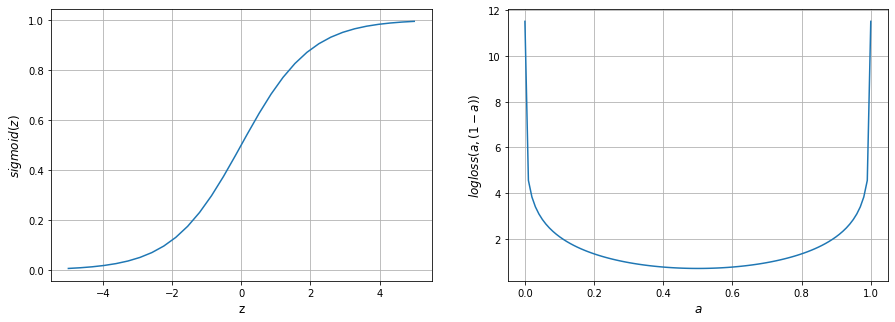

In [3]:
#Visualizemos como se comportan la funcion sigmoide y el error logistico

plt.figure(figsize=(15,5))

x = np.linspace(-5,5,30)
y = np.array([sigmoid(z) for z in x]) #comprehension

plt.subplot(121)
plt.grid()
plt.plot(x,y)
plt.xlabel("z", fontsize=12)
plt.ylabel(r'$sigmoid(z)$', fontsize=12)

plt.subplot(122)
epsilon = 1E-5
a = np.linspace(epsilon,1-epsilon, 100) #prediction
l = np.array([logloss(t,(1-t)) for t in a]) #comprehension

plt.grid()
plt.plot(a,l)
plt.xlabel(r'$a$', fontsize=12)
plt.ylabel(r'$logloss(a, (1-a))$', fontsize=12)

plt.show()

<hr>

## 1.2. Implementación tradicional

Ahora procedamos a implementar el grafo de cómputo del regresor logístico a partir de lo definido anteriormente.

In [4]:
# parametros del regresor
w = -0.5
b = -1.5

#ejemplo del dataset
x = -1.2
y = 1

z = w * x + b
a = sigmoid(z) #prediccion
l = logloss(a, y) #error logistico

print("Prediccion: %.4f "%(a))
print("Error: %.4f"%(l))

Prediccion: 0.2891 
Error: 1.2412


Ahora, la implementación anterior funciona para un solo ejemplo de un dataset, y por ello, en caso de querer computar todas las predicciones para un dataset, es necesario utilizar ciclos.

In [5]:
np.random.seed(2)

#dataset
X = np.random.random([10]) #100 inputs aleatorios
Y = np.round(np.random.random([10])) #100 clases aleatorias 0,1

#parametros del regresor
w = -0.5
b = -1.5

for (i,x) in enumerate(X):
    a = sigmoid(w * x + b)
    l = logloss(a, Y[i])
    
    print("prediccion - dato %i: %.4f"%(i,a))
    print("logloss - dato %i: %.4f"%(i,l))

prediccion - dato 0: 0.1521
logloss - dato 0: 1.8830
prediccion - dato 1: 0.1805
logloss - dato 1: 1.7120
prediccion - dato 2: 0.1449
logloss - dato 2: 0.1566
prediccion - dato 3: 0.1522
logloss - dato 3: 1.8827
prediccion - dato 4: 0.1531
logloss - dato 4: 0.1662
prediccion - dato 5: 0.1591
logloss - dato 5: 1.8384
prediccion - dato 6: 0.1677
logloss - dato 6: 1.7858
prediccion - dato 7: 0.1407
logloss - dato 7: 0.1516
prediccion - dato 8: 0.1611
logloss - dato 8: 1.8255
prediccion - dato 9: 0.1634
logloss - dato 9: 0.1784


<hr>

<font size=4>
    
__Analicemos__: 

En el ejemplo anterior, tanto la entrada como la salida tenian dimension $\rm I\!R$. Qué pasaría con la implementación anterior si la entrada tuviera dimensión $\rm I\!R^{2}?$

</font>

<hr>

## 1.3. Vectorization / Broadcasting

Algunas operaciones entre conjuntos de datos pueden ser vectorizadas y expandidas (broadcasted) en Python utilizando para ello algunas operaciones algebraicas y la librería Numpy. Este es el caso de la operacion $z = wx+b$ que para el caso en que $x \in \rm I\!R^{nx}$ equivale a la sumatoria de cada caracteristica por sample , multiplicada por su respectivo $w$, lo que finalmente equivale a un __producto punto__ (escalar) entre $x$ y $w$:

<br>

<font size=5><center>$\sum_j^{nx}{x_j*w_j} = w^T.x$</center></font>

Esto, además de facilitar la implementación del regresor, hace más eficiente su cálculo. Discutamos el siguiente ejemplo:

In [6]:
import numpy as np
from time import time

In [15]:
# Generemos 10 millones de datos y computemos la sumatoria de su productoria

np.random.seed(2)
n = int(10E6)
A = np.random.rand(n)
B = np.random.rand(n)

In [8]:
# Forma tradicional
tic = time()

s = 0
for i in range(n):
    s += A[i] * B[i]

toc = time()

print("Resultado: %.4f"%(s))
print("Tiempo transcurrido (ms)", (toc-tic)*1000)

Resultado: 2501003.0002
Tiempo transcurrido (ms) 8220.741987228394


In [16]:
# Forma vectorizada
tic = time()

s = np.dot(A, B)

toc = time()

print("Resultado: %.4f "%(s))
print("Tiempo transcurrido (ms)", (toc-tic)*1000)

Resultado: 2501003.0002 
Tiempo transcurrido (ms) 9.309053421020508


<hr>

Ahora, debemos considerar que nuestro dataset tiene un tamaño $m$, es decir, $m$ ejemplos, cada uno de dimensión $\rm I\!R^{nx}$. __Implica esto que ahora debamos hacer un ciclo para iterar por todo el dataset?__

La librería numpy soporta una operación conocida como __broadcast__, la cual permite replicar operaciones entre dos arreglos de distinta dimensión, siempre que estos compartan una de las dimensiones y uno de ellos tenga magnitud 1 en una de sus dimensiones. Para ello Python replicará uno de los dos vectores y ejecutará la operación. Esto se puede generalizar de la siguiente manera:

<br>

<center><font size=5>$A_{(m,n)} + B_{(m, 1)} \rightarrow  A_{(m,n)} + B_{(m, n)}$</font></center>
<center><font size=5>$A_{(m,n)} + B_{(1, n)} \rightarrow  A_{(m,n)} + B_{(m, n)}$</font></center>


Analicemos el siguiente ejemplo.

In [10]:
np.random.seed(2)

A = np.random.rand(4,3)
k = np.random.rand(4,1)

print("Array A: \n", A)
print("Array B: \n", k)

print("A + B:\n ",A+k)

Array A: 
 [[0.4359949  0.02592623 0.54966248]
 [0.43532239 0.4203678  0.33033482]
 [0.20464863 0.61927097 0.29965467]
 [0.26682728 0.62113383 0.52914209]]
Array B: 
 [[0.13457995]
 [0.51357812]
 [0.18443987]
 [0.78533515]]
A + B:
  [[0.57057485 0.16050618 0.68424242]
 [0.94890051 0.93394592 0.84391294]
 [0.3890885  0.80371083 0.48409454]
 [1.05216242 1.40646898 1.31447724]]


<hr>

## 1.4. Implementación vectorizada

A partir de lo anterior, entonces podemos concluir que el producto punto en Python vectoriza la operación $wX+b$ y a la vez extiende la operación para todos los datos del dataset por broadcast. Revisemos ahora la implementación vectorizada del regresor logístico.

In [11]:
def linear_activation(W, b, X):
    z = np.dot(W.T,X) + b
    
    return z

def sigmoid(z):
    a = 1. / (1. + np.exp(-z)) 
    
    return a 

def logloss(y, a):
    return -(y * np.log(a) + (1-y) * np.log(1-a))

def cost(L):
    return np.mean(L)

In [12]:
np.random.seed(2)

#dataset
X = np.random.random([1, 10]) #100 inputs aleatorios
Y = np.round(np.random.random([10])) #100 clases aleatorias 0,1

#parametros del regresor
w = np.array([-0.5])
b = -1.5

Z = linear_activation(w, b, X)
A = sigmoid(Z)
L = logloss(Y, A)
    
print("Predicciones: ",A,"\n")
print("Errores: ", L, "\n")
print("Error total (costo): ", cost(L))

Predicciones:  [0.15212928 0.18050007 0.14494255 0.15217266 0.15313986 0.15906955
 0.16765701 0.14068219 0.16113229 0.16336326] 

Errores:  [1.88302456 1.71202409 0.15658661 1.88273947 0.16621973 1.83841374
 1.78583499 0.15161644 1.82552959 0.17836531] 

Error total (costo):  1.1580354539596054


<hr>

## 1.5. Descenso del gradiente

El descenso del gradiente, es un algoritmo de optimización que utiliza el gradiente del error respecto a los parámetros de una función, para actualizar los mismos de manera iterativa hasta estabilizarse en un mínimo.

<br>

Sea $f(\theta)$ una función __diferenciable__ para la cual se desea encontrar el valor de $\theta$ tal que la minimice, el descenso del gradiente se puede plantear como:

<br>

<font size=3>
$
\\
repetir\{
\\
\hspace{10mm} d \theta = \frac{df}{d \theta}
\\
\hspace{10mm} \theta = \theta - \alpha d \theta
\\
\}
$
</font>


En el caso concreto del regresor logístico, nos interesa encontrar los parametros $w$ y $b$ tales que minicen el error $logloss$. En ese caso el descenso del gradiente queda:

<br>

<font size=3>
$
\\
repetir\{
\\
\hspace{10mm} dw = \frac{dLoss}{dw}
\\
\hspace{10mm} db = \frac{dLoss}{db}
\\
\hspace{10mm} w = w - \alpha. dw
\\
\hspace{10mm} b = b - \alpha. db
\\
\}
$
</font>

<hr>

<font size=3>
    
__Trabajemos__:

Desarrollemos las derivadas de los parámetros $w$ y $b$ a partir del gráfo de cómputo.

</font>

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/backprop.png?raw=true" width="700"/>

<hr>

Finalmente, el descenso del gradiente en implementación vectorizada queda definido como:

<br>

<i>
    
__FOR__ $i=1 \rightarrow$ epochs:

    //forward propagation
    Z = W.T*X+b
    A = sig(Z)
    
    //cálculo de los gradientes de los parámetros
    dz = A-Y
    dW = (X*dz.T) / m
    db = sum(dz) / m
    
    //cálculo del costo
    J = cost(loss(Y,A))
    
    //actualizacion de parametros
    W = W - learning_rate*dW
    b = b - learning_rate*db
__END FOR__
    
</i>


<br>

Implementemos el proceso completo con descenso del gradiente, utilizando los conceptos de vectorization y brocasting. Para ello, generemos primero un dataset sintético de clasificación binaria mediante las siguientes funciones utilitarias.

In [191]:
'''
Utility functions
'''

import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_data(data_type, noise=0.2):
    """
    Generate a binary dataset with distribution data_type

    Arguments:
    data_type -- distribution of dataset {moons,circles,blobs}

    Returns:
    X -- features
    Y -- labels
    """ 
    np.random.seed(0)
    if data_type == 'moons':
        X, Y = datasets.make_moons(200, noise=noise)
    elif data_type == 'circles':
        X, Y = sklearn.datasets.make_circles(200, noise=noise)
    elif data_type == 'blobs':
        X, Y = sklearn.datasets.make_blobs(centers=2, cluster_std=noise)
    return X, Y

def predict(W,b,X):
    z = linear_activation(W,b,X)
    A = sigmoid(z)
    return np.round(A)
    #return A

def visualize_lr(W, b, X, y):
    """
    Plots a classification boundary for a logistic regression model
    defined by W and b, using X (inputs) and y (outputs)

    Arguments:
    data_type -- distribution of dataset {moons,circles,blobs}

    Returns:
    W -- weights of lr model
    b -- bias of lr model
    X -- features
    y -- labels
    """
    X = X.T
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(W,b,np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    #plt.figure(figsize=(7,5))
    #plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    
    return (X, color, xx, yy, Z)
    #plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Spectral, c=color)
    #plt.show()

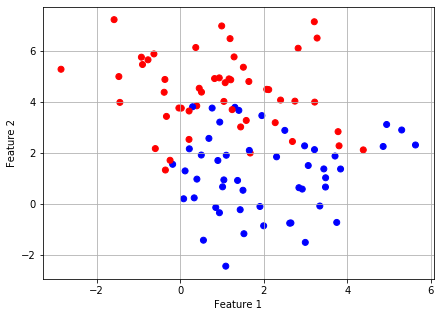

Size(X):  (2, 100)
Size(Y):  (1, 100)


In [188]:
X, Y = generate_data('blobs', 1.5)
Y = Y.reshape(1,len(Y))

color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)] # una lista para darle color a las clases

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()

plt.show()

X = X.T

print("Size(X): ", X.shape)
print("Size(Y): ", Y.shape)

In [189]:
#Regresor logistico + Descenso del gradiente

np.random.seed(2)

#1.  Parametros del dataset
m = len(X) #numero de ejemplos en el dataset.
nx = X.shape[0] #dimensionalidad de la entrada o numero de features.

#1. Parametros del regresor
W = np.random.random([nx, 1]) # W tiene una tamanio de (nx, 1)
b = np.random.random()

print("W inicial: ", W)
print("b inicial: ", b)

#2 . Parametros del descenso del gradiente
learning_rate = 0.005
num_epochs = 100

#3. Estructuras utilitarias
history = [] #lista para almacenar el valor de cada 

for i in range(num_epochs): #1000 iteraciones del descenso del gradiente
    '''
    Activacion hacia adelante
    '''
    Z = linear_activation(W,b,X)
    A = sigmoid(Z)
    
    '''
    Activacion hacia atras - retropropagacion del error
    '''
    dz = A - Y
    dW = np.dot(X,dz.T) / m
    db = np.sum(dz) / m
    
    '''
    Actualizacion de parametros mediante descenso del gradiente
    '''
    W -= learning_rate * dW
    b -= learning_rate * db
    
    l = logloss(Y,A)
    J = cost(l)

    history.append(J)

print("W actualizado: ",W)
print("b actualizado: ",b)
print("costo total: ", J)

W inicial:  [[0.4359949 ]
 [0.02592623]]
b inicial:  0.5496624778787091
W actualizado:  [[ 0.50963713]
 [-0.91750694]]
b actualizado:  1.5264243068508327
costo total:  0.341692183471116


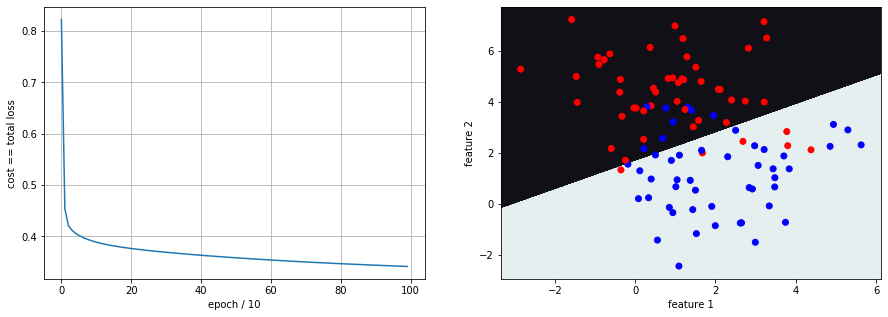

In [192]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history)
plt.xlabel("epoch / 10")
plt.ylabel("cost == total loss")
plt.grid()

(X_pred, color, xx, yy, Z) = visualize_lr(W, b, X, Y)
plt.subplot(122)
plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
plt.scatter(X_pred[:, 0], X_pred[:, 1], cmap=plt.cm.Spectral, c=color)
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.show()

<hr>

<font size=4>
    
__Analicemos__: 

1. Observe que el valor de la tasa de aprendizaje (learning_rate) es 0.005. Qué sucede con la convergencia del algoritmo si utilizamos un valor mayor, por ejemplo, $\alpha = 0.05$ o un valor menor, por ejemplo, $\alpha=1E-5$?


2. En los scripts utilitarios modifique la función __predict__ para que no redondee la predicción. Que puede observar?

</font>